<a href="https://colab.research.google.com/github/mcastillogalan/Mathematicas-Grupo-18/blob/main/07MIAR_PP_Grupal_Marta_Raul_Unai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07MIAR - Redes Neuronales y Deep Learning: Proyecto de programación "*Shoe vs Sandal vs Boot Image Dataset (15K Images)*"


**Integrantes del grupo:**

- Marta Castillo Galán
- Unai Marín Etxebarria
- Raúl Murillo Gallego

**Enunciado:**

En esta actividad, el alumno **debe evaluar y comparar dos estrategias **para la **clasificación de imágenes** empleando el dataset asignado. Los alumnos deberá resolver el reto proponiendo una solución válida **basada en aprendizaje profundo**, más concretamente en redes neuronales convolucionales (**CNNs**). Será indispensable que la solución propuesta siga el **pipeline visto en clase** para resolver este tipo de tareas de inteligencia artificial:

# **1º Preparación de entorno de trabajo**

- Usar Google Colab con GPU.
- Crear estructura de carpetas y definir BASE_FOLDER


In [1]:
# Se comprueba que se tenga instalada la última versión de la API de Kaggle en Colab
!pip install --upgrade --force-reinstall --no-deps kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.2
    Uninstalling kaggle-1.7.4.2:
      Successfully uninstalled kaggle-1.7.4.2


In [4]:
# Se importan todas la librerias que vamos a necesitar en el proyecto de trabajo
from google.colab import files
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
import seaborn as sns
import tensorflow as tf

# Se crea la carpeta del dataset
BASE_FOLDER = "/content/07MIAR_Proyecto_Programacion/Shoe vs Sandal vs Boot Dataset"

# **2º. Cargar el Dataset desde Kaggle**

En este caso, debemos descargar el conjunto de datos perteneciente al Dataset número 13 (Shoe vs Sandal vs Boot Image Dataset (15K Images))

- Obtener y subir kaggle.json.
- Instalar y configurar la API de Kaggle.
- Descargar y descomprimir el dataset.

**Nota para el grupo:**

En el directorio de trabajo de GitHub he dejado el archivo *kaggle.json* para que lo podáis cargar a continuación...

In [5]:
# Para poder descargarse el dataset se debe de disponer de API Key (username/key)
# Se procede a cargar el archivo con las claves de la API Key que está guardado en el directorio habilitado de GitHub compartido por el grupo de trabajo
uploaded = files.upload()

for filename in uploaded:
    content = uploaded[filename]
    # Process the file content (e.g., save to a file, read data)
    print(f'Uploaded file "{filename}" with {len(content)} bytes')

Saving kaggle.json to kaggle.json
Uploaded file "kaggle.json" with 62 bytes


In [6]:
# Se crea un directorio en el que se copia el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Se guarda en su directorio correspondiente. En esta ocasión el directorio de trabajo va a estar ubicado en /Content/07MIAR_Proyecto_Programacion
!mkdir -p /content/07MIAR_Proyecto_Programacion

In [8]:
# Desde Kaggle, descargamos el zip con todas la imagenes
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images -p /content/07MIAR_Proyecto_Programacion

Dataset URL: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
License(s): copyright-authors


In [10]:
#Descomprimimos el Zip y lo guardamos en su carpeta correspondiente
!unzip -q /content/07MIAR_Proyecto_Programacion/shoe-vs-sandal-vs-boot-dataset-15k-images.zip -d /content/07MIAR_Proyecto_Programacion

# **3º Inspección del dataset**

- Mostrar imágenes.
- Revisar clases y balanceo del dataset.


Clases encontradas: ['Shoe', 'Sandal', 'Boot']
Distribución por clase: {'Shoe': 5000, 'Sandal': 5000, 'Boot': 5000}



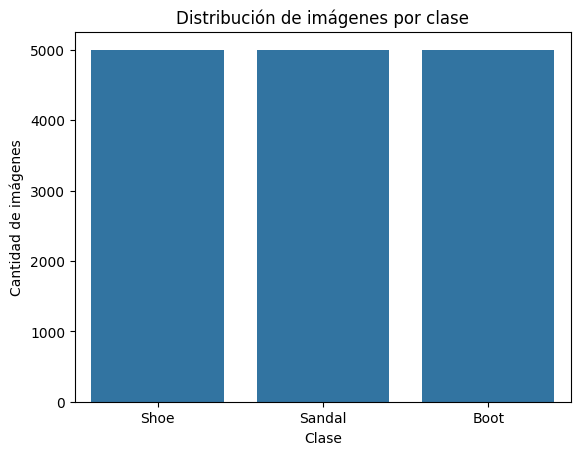


Muestra de imagenes aleatorias por clases:


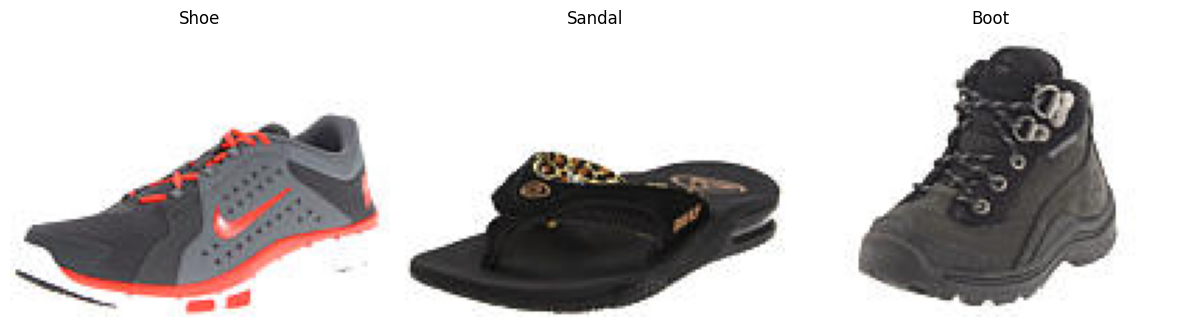

In [11]:
# Mostrar clases
clases = os.listdir(BASE_FOLDER)
print(f"Clases encontradas: {clases}")

# Contar imágenes por clase
conteo = {clase: len(os.listdir(os.path.join(BASE_FOLDER, clase))) for clase in clases}
print("Distribución por clase:", conteo)
print("")

# Visualizar el balance de clases
sns.barplot(x=list(conteo.keys()), y=list(conteo.values()))
plt.title("Distribución de imágenes por clase")
plt.ylabel("Cantidad de imágenes")
plt.xlabel("Clase")
plt.show()

print("")
print("Muestra de imagenes aleatorias por clases:")
# Mostrar algunas imágenes aleatorias
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, clase in zip(axes, clases):
    imagen_path = random.choice(os.listdir(os.path.join(BASE_FOLDER, clase)))
    img = Image.open(os.path.join(BASE_FOLDER, clase, imagen_path))
    ax.imshow(img)
    ax.set_title(clase)
    ax.axis('off')
plt.tight_layout()
plt.show()

# **4º. Acondicionamiento del Dataset (Preprocesamiento)**

- Normalización.
- Redimensionamiento.
- Data augmentation con ImageDataGenerator.


In [12]:
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator

# Tamaño de imagen
img_size = (150, 150)
batch_size = 32

# Generador para entrenamiento con augmentación
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalización
    validation_split=0.2,  # Usamos 20% para validación
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generador para validación (sin augmentación)
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Crear flujos desde el directorio
train_generator = train_datagen.flow_from_directory(
    BASE_FOLDER,
    target_size=img_size,   # Redimensionado
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_generator = valid_datagen.flow_from_directory(
    BASE_FOLDER,
    target_size=img_size,   # Redimensionado
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


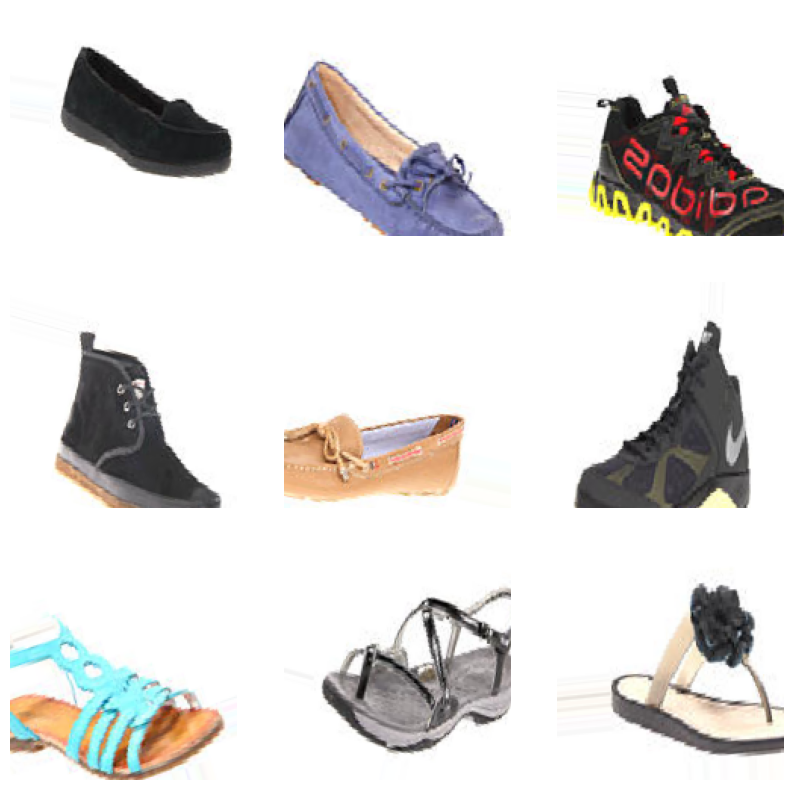

In [13]:
# Obtener un lote de imágenes
x_batch, y_batch = next(train_generator)

# Mostrar algunas imágenes del lote
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()


# **5º. Estrategia 1: CNN DESDE CERO**

A continuación vamos a generar, desarrollar una red neuronal convolucional, desde cero, que sea capaz de distinguir adecuadamente entre las imágenes de botas, zapatillas y sandalias. De entrada, queremos advertir que una red neuronal profunda que ejecute dicha tarea de manera, como decimos, adecuada, requiere del entrenamiento de miles, quizá millones de parámetros, y una cantidad considerable de ajustes y pruebas. Por lo tanto, si bien trataremos de justificar las razones detrás de las elecciones que hacemos, y parte del ensayo prueba y error, debe quedar claro que la mayor parte del proceso queda fuera del escrito, tanto por el tiempo de entrenamiento requerido como por extensión y claridad. Veamos.

Empecemos por importar las librerías que usaremos a lo largo del proceso, y que iremos desgranando poco a poco.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

#### MODELO INICIAL

Un modelo secuencial en Keras es la forma más sencilla de construir una red neuronal. Se llama secuencial porque las capas se añaden una tras otra, en orden lineal, como si fueran "bloques apilados". Al principio por lo tanto, tenemos una red "vacía".

In [ ]:
model = Sequential()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Vamos a por la primera capa, obviamente convolucional. Una capa convolucional es aquella que opera por regiones de la imagen, aplicando distintos "filtros" (es decir, modificando los bits o sustituyendo conjuntos de bits por un bit en base a los pesos y el proceso de filtro). En concreto, esta capa que utilizaremos produce 16 filtros diferentes. En términos de bits de entrada y de salida, tenemos:

- Entrada:
  - Tamaño: (150, 150, 3) → imagen de 150x150 píxeles con 3 canales (RGB).
  - Total de valores: 150 × 150 × 3 = 67,500 valores de entrada (floats entre 0 y 1).
    
- Salida
    - Si no hay padding, el tamaño se reduce (por ejemplo, a 148×148×16).
    - Total de valores de salida: 150 × 150 × 16 = 350,464 valores (uno por píxel por filtro).

Finalmente, utilizamos la función de actividad ReLU en esta capa. Veamos el estado de la red actual.


In [ ]:
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448 (1.75 KB)

 Trainable params: 448 (1.75 KB)

 Non-trainable params: 0 (0.00 B)

Tengamos en cuenta que cada imágen tiene 21.904 bits. A medida que avancemos en las capas, enseguida explotará la cantidad de parámetros a entrenar. Por eso debemos reducir la dimensionalidad de la imágen, con un mapa tipo Pooling. En este caso utilizaremos la técnica MaxPooling2D, que toma el valor máximo de cada bloque 4x4 de la imagen de entrada y lo sustituye por el bloque. Con esto, reduciremos la cantidad de bits a una decimosexta parte.

In [ ]:
model.add(MaxPooling2D(pool_size=(4, 4)))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 16)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448 (1.75 KB)

 Trainable params: 448 (1.75 KB)

 Non-trainable params: 0 (0.00 B)

Por simplicidad, probemos a cerrar esta red y testearla, antes de si quiera probar las diferentes técnicas de regularización y demás que existen. Para ello, aplanamos las 16 imágenes de 37x37 a un array de 21.904 bits.

In [ ]:
model.add(Flatten())
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21904)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448 (1.75 KB)

 Trainable params: 448 (1.75 KB)

 Non-trainable params: 0 (0.00 B)

Finalmente, debemos conectar todos eso bits a tres bits de salida, cada uno correspondiente a una etiqueta. Utilizamos la función de activación softmax para que las salidas de la red sean probabilidades y sumen 1, lo que nos permite interpretar los resultados como una probabilidad de que la imagen pertenezca a cada clase.

In [ ]:
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21904)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        65,715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,163 (258.45 KB)

 Trainable params: 66,163 (258.45 KB)

 Non-trainable params: 0 (0.00 B)

Como vemos, aún así obtenemos una red de 66163 parámetros, que no es poca cosa para un ordenador convencional. Nos disponemos a compilar y entrenar la red. Por una parte, utilizamos el optimizar Adam porque es un optimizador eficiente y adaptativo, que ajusta automáticamente las tasas de aprendizaje para cada parámetro durante el entrenamiento. Por otra, utilizamos categorical_crossentropy para medir el error cometido entre el vector real (por ejemplo, [1,0,0]] y el predicho ([0.77, 0.23, 0]). Finalmente, accuracy es una de las métricas más intuitivas que hay, y por lo tanto la suamos.

#### Explicación del Entrenamiento:

- train_generator: El generador de entrenamiento que hemos creado previamente, que alimenta las imágenes de entrenamiento.

- epochs=10: El número máximo de épocas. Este número es un valor inicial; si el entrenamiento se detiene antes debido al EarlyStopping, se evitará continuar innecesariamente. En este caso, utilizamos un número pequeño de épocas, ya que es un modelo temporal, y por lo tanto el EarlyStopping no es realmente demasiado ventajoso aquí.
- validation_data=val_generator: El generador de datos de validación.

- callbacks=[early_stopping]: Usamos EarlyStopping como un callback para detener el entrenamiento si la pérdida de validación no mejora durante 5 épocas consecutivas (patience=5). Además, restore_best_weights=True asegura que los mejores pesos del modelo (con el menor valor de pérdida de validación) se restauren al final del entrenamiento.

- steps_per_epoch y validation_steps: Estos parámetros son el número de pasos que el generador debe tomar en cada época. Se calculan dividiendo el tamaño total del conjunto de datos por el tamaño del lote (batch size).

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping: Monitoriza la pérdida de validación y detiene el entrenamiento si no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(
    train_generator,  # Generador de datos de entrenamiento
    epochs=10,  # Número máximo de épocas
    validation_data=valid_generator,  # Generador de datos de validación
    callbacks=[early_stopping],  # Usamos EarlyStopping como callback
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Número de pasos por época (tamaño del dataset / batch_size)
    validation_steps=valid_generator.samples // valid_generator.batch_size  # Número de pasos por época de validación
)



C:\Users\Unai\Documents\ANACONDA\envs\MASTER_IA\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 117s 310ms/step - accuracy: 0.5173 - loss: 1.1979 - val_accuracy: 0.6865 - val_loss: 0.6718
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 123s 329ms/step - accuracy: 0.6534 - loss: 0.7694 - val_accuracy: 0.7611 - val_loss: 0.5435
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 101s 268ms/step - accuracy: 0.6827 - loss: 0.7213 - val_accuracy: 0.7265 - val_loss: 0.5716
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 101s 269ms/step - accuracy: 0.6922 - loss: 0.6947 - val_accuracy: 0.7681 - val_loss: 0.5233
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 86s 229ms/step - accuracy: 0.7034 - loss: 0.6766 - val_accuracy: 0.7705 - val_loss: 0.5500
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 195ms/step - accuracy: 0.7307 - loss: 0.6437 - val_accuracy: 0.7708 - val_loss: 0.5401
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 200ms/step - accuracy: 0.7275 - loss: 0.6429 - val_accuracy: 0.7759 - val_loss: 0.5369
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 201ms/step - accuracy: 0.7347 - los

Como vemos, incluso este modelo tan simple acierta más del 80% de las veces, contra un dataset balanceado (por lo que accuracy sigue siendo una buena métrica). Guardémoslo.

In [ ]:
model.save('modelo_temporal.h5')

Ahora, visualizaremos el desarrollo de las métricas durante el entrenamiento.

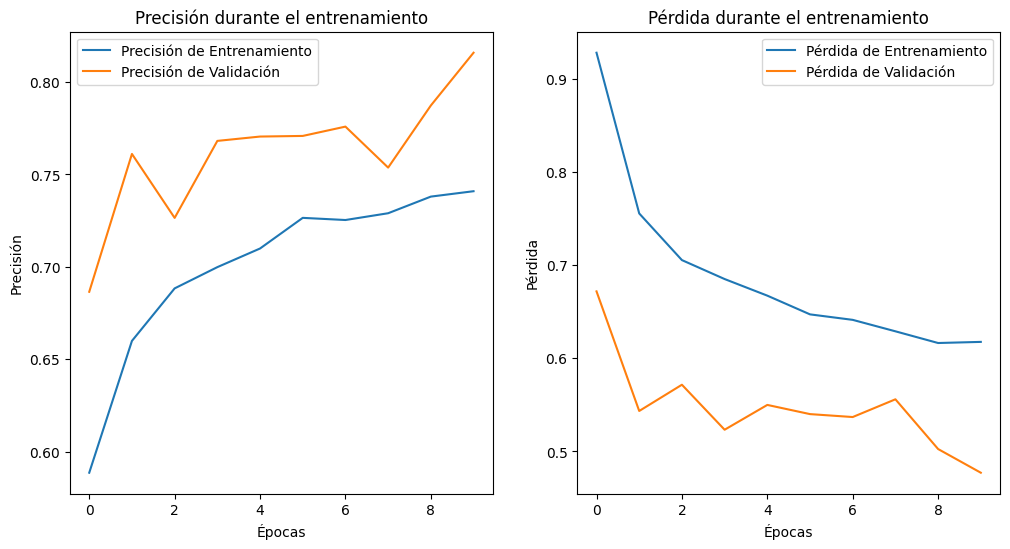

In [ ]:
import matplotlib.pyplot as plt

# Obtener los datos de la historia del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Graficar precisión
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Precisión de Entrenamiento')
plt.plot(val_acc, label='Precisión de Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar pérdida
plt.subplot(1, 2, 2)
plt.plot(loss, label='Pérdida de Entrenamiento')
plt.plot(val_loss, label='Pérdida de Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()


Como se puede observar, las métricas han resultado ser siempre mejor en el conjunto de validación que en el de entrenamiento, por lo que no cabe hablar de sobreajuste. De hecho, todo apunta a que un mayor número de épocas podría mejorar todavía más el rendimiento del modelo. Sin embargo, trataremos de desarrollar una red más compleja, en la que incorporaremos diversos mecanismos de regularización.

#### CNN CON REGULARIZACIÓN

Comenzamos igual que antes, con la inicialización, la primera capa convolucional y un MaxPooling2D. Podríamos tratar de usar un AveragePooling, que en vez de coger el máximo de cada bloque, se quede con la media, pero para problemas de clasificación es más util usar un Pooling agresivo, que se quede con los bits más destacados.

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(4, 4)))

Sin embargo, esta vez aplicaremos un Dropout en este lugar de la red. Por ejemplo, utilizaremos un Dropout de 0.2; durante el entrenamiento, 20% de las neuronas se desactivan aleatoriamente en esta capa. Esto hace que la red no dependa de neuronas específicas y mejora la generalización.

In [ ]:
model.add(Dropout(0.2))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 37, 16)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 448 (1.75 KB)

 Trainable params: 448 (1.75 KB)

 Non-trainable params: 0 (0.00 B)

En este punto, añadimos una capa similar a la primera, pero con más filtros (64) para extraer características de mayor nivel y más complejas. Por lo demás, las capas de MaxPooling continúan reduciendo la dimensionalidad espacial (esta vez en bloques de 2x2) y el Dropout también ayuda a prevenir el sobreajuste.

In [ ]:
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 35, 35, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 17, 64)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,728 (38.00 KB)

 Trainable params: 9,728 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

Aplicamos ahora Batch Normalization. En pocas palabras, durante el entrenamiento, en cada mini-lote de datos, normalizamos la salida de una capa para que tenga:

- Media ≈ 0
- Desviación estándar ≈ 1

Luego aplicamos dos parámetros aprendibles: un escaleado (gamma) y un desplazamiento (beta), para que la red pueda ajustar si quiere deshacer esa normalización.

In [ ]:
model.add(BatchNormalization())
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 35, 35, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 17, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,984 (39.00 KB)

 Trainable params: 9,856 (38.50 KB)

 Non-trainable params: 128 (512.00 B)

Al igual que antes, aplanamos esta capa.

In [ ]:
model.add(Flatten())
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 35, 35, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 17, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18496)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,984 (39.00 KB)

 Trainable params: 9,856 (38.50 KB)

 Non-trainable params: 128 (512.00 B)

Si bien parece que no estemos complicando demasiado el modelo con respecto al primero, ahora mismo nos disponemos a añadir una capa densa con regularización L2, que incrementará muchísimo el número de parámetros. Es decir, podríamos afirmar que el trabajo de las primeras capas convolucionales es extraer patrones locales de las imágenes, y dejarlas preparadas para que las siguientes capas exploten el resto de patrones implícitos.

Como decimos, aplicamos:

- Dense(256): Una capa densa con 256 neuronas que conecta todas las neuronas de la capa anterior. Activación ReLU.

- L2 Regularization: Regularización L2 aplicada a los pesos de la capa densa para evitar que los pesos crezcan demasiado y mejorar la generalización.

- Dropout(0.5): Se aplica 50% de Dropout en esta capa densa para prevenir el sobreajuste, ya que contamos con muchas conexiones.

In [ ]:
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 35, 35, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 17, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     4,735,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,745,216 (18.10 MB)

 Trainable params: 4,745,088 (18.10 MB)

 Non-trainable params: 128 (512.00 B)

Por último, añadimos igual que antes la capa de salida.

In [ ]:
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 35, 35, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 17, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     4,735,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,745,987 (18.10 MB)

 Trainable params: 4,745,859 (18.10 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# EarlyStopping: Monitoriza la pérdida de validación y detiene el entrenamiento si no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(
    train_generator,  # Generador de datos de entrenamiento
    epochs=50,  # Número máximo de épocas
    validation_data=valid_generator,  # Generador de datos de validación
    callbacks=[early_stopping],  # Usamos EarlyStopping como callback
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Número de pasos por época (tamaño del dataset / batch_size)
    validation_steps=valid_generator.samples // valid_generator.batch_size  # Número de pasos por época de validación
)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 155s 411ms/step - accuracy: 0.5499 - loss: 5.6023 - val_accuracy: 0.4808 - val_loss: 2.8722
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 115s 307ms/step - accuracy: 0.6763 - loss: 1.8210 - val_accuracy: 0.5763 - val_loss: 2.9791
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 105s 279ms/step - accuracy: 0.7225 - loss: 1.4031 - val_accuracy: 0.7026 - val_loss: 1.5081
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 106s 282ms/step - accuracy: 0.7435 - loss: 1.2614 - val_accuracy: 0.6536 - val_loss: 1.4943
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 106s 283ms/step - accuracy: 0.7649 - loss: 1.1452 - val_accuracy: 0.5383 - val_loss: 1.5917
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 107s 285ms/step - accuracy: 0.7643 - loss: 1.1858 - val_accuracy: 0.6919 - val_loss: 1.6064
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 105s 281ms/step - accuracy: 0.7657 - loss: 1.2111 - val_accuracy: 0.7782 - val_loss: 1.1135
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 106s 281ms/step - accuracy: 0.7783 -

Veamos las curvas de entrenamiento.

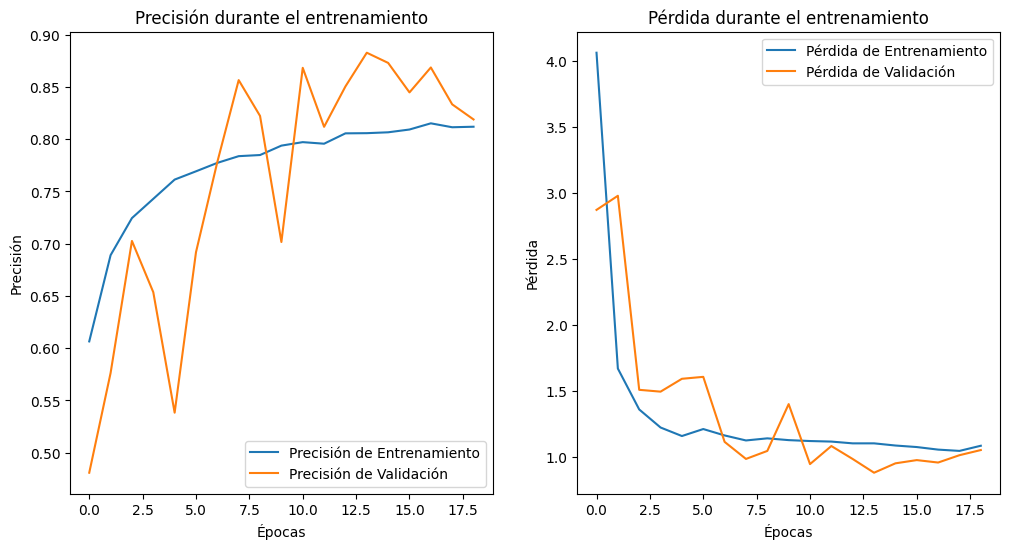

In [ ]:
import matplotlib.pyplot as plt

# Obtener los datos de la historia del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Graficar precisión
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Precisión de Entrenamiento')
plt.plot(val_acc, label='Precisión de Validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar pérdida
plt.subplot(1, 2, 2)
plt.plot(loss, label='Pérdida de Entrenamiento')
plt.plot(val_loss, label='Pérdida de Validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()


Como vemos, el entrenamiento de esta red es más caótico, probablemente por tratarse de un modelo mucho más complejo. Sin embargo, no parece mejorar los resultados del primero, aun siendo considerablemente más costoso en términos computacionales.

Pero, lo más importante, puede observarse que incluso ha comenzado a manifestarse un sobreajuste en las últimas épocas del entrenamiento. Por lo tanto, intentaremos construir un modelo más simple, evitando sobreajuste y economizando los recursos, y trataremos de mejorar los dos anteriores.

In [ ]:
model.save('modelo_regulado.h5')

#### CNN DEFINITIVA

Esperamos que en este punto el siguiente código sea facilmente interpretable. Eliminamos la penúltima capa densa, pero añadimos más capas convolucionales, que sean capaces de extraer más filtro, y por lo tanto patrones de las imágenes.

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Flatten())
#model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │       110,979 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,075 (762.01 KB)

 Trainable params: 194,819 (761.01 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# EarlyStopping: Monitoriza la pérdida de validación y detiene el entrenamiento si no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(
    train_generator,  # Generador de datos de entrenamiento
    epochs=50,  # Número máximo de épocas
    validation_data=valid_generator,  # Generador de datos de validación
    callbacks=[early_stopping],  # Usamos EarlyStopping como callback
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=valid_generator.samples // valid_generator.batch_size  # Número de pasos por época de validación
)# Número de pasos por época (tamaño del dataset / batch_size)


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 226s 599ms/step - accuracy: 0.5108 - loss: 1.4081 - val_accuracy: 0.4499 - val_loss: 1.0716
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 202s 540ms/step - accuracy: 0.6848 - loss: 0.8212 - val_accuracy: 0.5370 - val_loss: 1.3445
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 198s 527ms/step - accuracy: 0.7341 - loss: 0.7199 - val_accuracy: 0.8280 - val_loss: 0.4996
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 220s 587ms/step - accuracy: 0.7473 - loss: 0.6792 - val_accuracy: 0.7446 - val_loss: 0.6517
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 198s 530ms/step - accuracy: 0.7504 - loss: 0.6646 - val_accuracy: 0.8589 - val_loss: 0.4376
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 154s 409ms/step - accuracy: 0.7797 - loss: 0.6161 - val_accuracy: 0.7204 - val_loss: 0.7360
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 164s 436ms/step - accuracy: 0.7921 - loss: 0.6121 - val_accuracy: 0.8401 - val_loss: 0.4951
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 161s 428ms/step - accuracy: 0.7806 -

In [ ]:
# Evaluar el modelo en el conjunto de prueba (puedes crear un generador de prueba similar al de validación)
target_size=(150, 150)
test_dir = '/content/07MIAR_Proyecto_Programacion/Shoe vs Sandal vs Boot Dataset'  # Directorio con datos de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical'
)

# Evaluación final
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Pérdida en conjunto de prueba: {test_loss}')
print(f'Precisión en conjunto de prueba: {test_accuracy}')

Found 15000 images belonging to 3 classes.
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.9102 - loss: 0.3477
Pérdida en conjunto de prueba: 0.351062148809433
Precisión en conjunto de prueba: 0.9074000120162964


Tras el entrenamiento y el testeo, vemos que hemos obtenido un accuracy de más del 90%, lo cual es un resultado muy bueno, para el cual hemos combinado la capacidad extractiva de las capas convolucionales, simplicidad en el modelo y técnicas de regularización. Pongámoslo a prueba.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


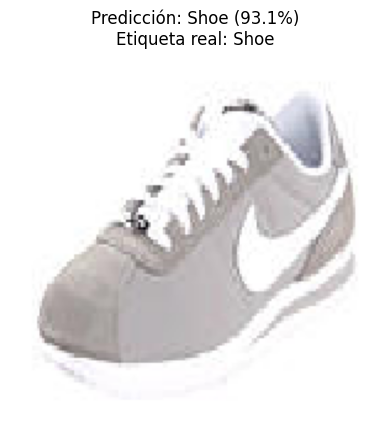

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Tomamos un batch del generador de validación
sample_images, sample_labels = next(valid_generator)

# Seleccionamos la primera imagen del batch
sample_img = sample_images[0]  # shape: (150, 150, 3)
true_label = sample_labels[0]

# Hacemos predicción
prediction = model.predict(np.expand_dims(sample_img, axis=0))  # shape: (1, 150, 150, 3)
predicted_class = np.argmax(prediction)
true_class = np.argmax(true_label)

# Diccionario de clases
class_indices = valid_generator.class_indices
class_names = list(class_indices.keys())

# Mostrar resultados
plt.imshow(sample_img)
plt.title(f'Predicción: {class_names[predicted_class]} ({np.max(prediction)*100:.1f}%)\nEtiqueta real: {class_names[true_class]}')
plt.axis('off')
plt.show()

# **6º. Estrategia 2: Transfer Learning y Fine-Tuning**
A continuación vamos a utilizar rede preentrenadas con el dataset ImageNet, llevando a cabo tareas de transfer learning y fine-tuning, que sea capaz de distinguir adecuadamente entre las imágenes de botas, zapatillas y sandalias.

En este trabajo vamos a comparar tres tipos de arquitecturas (https://keras.io/api/applications/):
- Xception
- InceptionResNetV2
- MobileNetV2  

In [ ]:
# Cargamos las librerias que vamos a necesitar
from tensorflow.keras.applications import MobileNetV2, Xception, InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Parámetros que vamos a usar
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 3

El *Transfer Learning* consiste en reutilizar un modelo preentrenado en un conjunto de datos grande como punto de partida para una nueva tarea relacionada, típicamente con menos datos disponibles. Se carga un modelo preentrenado, se eliminan las capas finales del modelo original, se agregan nuevas capas personalizadas que se ajusten al problema objetivo. Las capas convolucionales del modelo base se congelan, lo que significa que no se actualizan sus pesos durante el entrenamiento. Se entrena solo la parte superior agregada, permitiendo que el modelo aprenda a mapear las características generales extraídas a las clases específicas del nuevo conjunto de datos.

El *Fine-Tuning* consiste en descongelar parcialmente (o totalmente) el modelo preentrenado y entrenarlo junto con las nuevas capas superiores. Se hace después del transfer learning básico, para refinar las representaciones del modelo a la nueva tarea. Primero se entrena solo la parte superior (como en transfer learning), luego se descongelan algunas capas profundas del modelo base (generalmente las últimas, más específicas). Se reduce la tasa de aprendizaje porque los pesos ya están bien inicializados, se entrena todo el modelo conjuntamente, permitiendo que se adapten también las representaciones internas del modelo base a las características del nuevo dominio.

## XCEPTION

In [ ]:
# Cargamos Xception sin la capa de clasificación final
xception = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    input_tensor=None,
    pooling=None,
    classes=3,
    classifier_activation="softmax",
    name='my_xception')
xception.summary()
xception.trainable = False  # Congelamos capas para hacer transfer learning

Explicación de los parámetros (que son los mismos en las otras dos arquitecturas):
- weights: carga los pesos preentrenados de ImageNet.
- include_top: False excluye las capas densas del final del modelo, es decir, la capa de clasificación.
- input_shape: define la forma de entrada esperada para las imágenes (siempre con 3 canales RGB).
- input_tensor: puedes pasar un tensor de entrada personalizado, si es None el modelo crea un Input tensor automáticamente.
- pooling: determina si se aplica un pooling global tras la última capa convolucional cuando include_top=False. Opciones: 'avg', 'max', None.
- classes: número de clases para la clasificación de tus datos.
- classifier_activation: activación usada en la capa final de clasificación (Dense(classes)).
- name: asigna un nombre al modelo.

In [ ]:
# Creamos el modelo personalizado con nuestros datos encima del xception
# Usamos las técnicas vistas en clase de regularización y añadimos la capa de clasificación
x = xception.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
model_xception = Model(inputs=xception.input, outputs=predictions)

# Compilamos el modelo
model_xception.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("xception_best_model.h5", save_best_only=True)]

In [ ]:
# Entrenamiento Xception (Transfer Learning)
history_xception = model_xception.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=callbacks
)
# estos parámetros se han explicado en la estrategia 1

In [ ]:
# Fine-tuning Xception: desbloqueamos algunas capas superiores del modelo base
xception.trainable = True
for layer in xception.layers[:-50]:
    layer.trainable = False

model_xception.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento (Fine-tuning)
fine_tune_history_xception = model_xception.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=callbacks
)

## INCEPTIONRESNETV2

In [ ]:
# Cargamos InceptionResNetV2 sin la capa de clasificación final
inception = InceptionResNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    input_tensor=None,
    pooling=None,
    classes=3,
    classifier_activation="softmax",
    name='my_inception')
inception.summary()
inception.trainable = False  # Congelamos capas para hacer transfer learning

In [ ]:
# Creamos modelo personalizado con nuestros datos encima del inception
# Usamos las técnicas vistas en clase de regularización y añadimos la capa de clasificación
x = inception.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
model_inception = Model(inputs=inception.input, outputs=predictions)

# Compilamos el modelo
model_inception.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("inception_best_model.h5", save_best_only=True)]

In [ ]:
# Entrenamiento Inception (Transfer Learning)
history_inception = model_inception.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=callbacks
)

In [ ]:
# Fine-tuning Inception: desbloqueamos algunas capas superiores del modelo base
inception.trainable = True
for layer in inception.layers[:-50]:
    layer.trainable = False

model_inception.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento (Fine-tuning)
fine_tune_history_inception = model_inception.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=callbacks
)

## MOBILENETV2

In [ ]:
# Cargar MobileNetV2 sin la capa de clasificación final
mobile_net = MobileNetV2(
    alpha=1.0,
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    input_tensor=None,
    pooling=None,
    classes=3,
    classifier_activation="softmax",
    name='my_mobile_net')
mobile_net.summary()
mobile_net.trainable = False  # Congelamos capas para hacer transfer learning

In [ ]:
# Creamos modelo personalizado con nuestros datos encima del mobile_net
# Usamos las técnicas vistas en clase de regularización y añadimos la capa de clasificación
x = mobile_net.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
model_mobile_net = Model(inputs=mobile_net.input, outputs=predictions)

# Compilamos el modelo
model_mobile_net.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("mobilenetv2_best_model.h5", save_best_only=True)]

In [ ]:
# Entrenamiento MobileResNet (Transfer Learning)
history_mobile_net = model_mobile_net.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=callbacks
)

In [ ]:
# Fine-tuning MobileResNet: desbloqueamos algunas capas superiores del modelo base
mobile_net.trainable = True
for layer in mobile_net.layers[:-50]:
    layer.trainable = False

model_mobile_net.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento (Fine-tuning)
fine_tune_history_mobile_net = model_mobile_net.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=callbacks
)

## COMPARACIÓN DE LOS MODELOS

Una vez tenemos los modelos entrenados con nuestros datos, tenemos que elegir uno de ellos. Para ello vamos a ver las gráficas de precisión y de pérdida de todos (y ver cómo afecta el fine-tuning). Y elegiremos el que mayor precisión propone, según como nos indica el enunciado

In [ ]:
# Creamos una función para simplicar el pintar las gráficas

def plot_transfer_vs_finetune(history, fine_tune_history):
    # Unimos los historiales
    acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
    val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
    loss = history.history['loss'] + fine_tune_history.history['loss']
    val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

    total_epochs = len(acc)

    # Gráfica de precisión
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(total_epochs), acc, label='Entrenamiento')
    plt.plot(range(total_epochs), val_acc, label='Validación')
    plt.axvline(x=len(history.history['accuracy']) - 1, color='r', linestyle='--', label='Inicio fine-tuning')
    plt.title('Precisión durante Transfer Learning y Fine-tuning')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()

    # Gráfica de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(range(total_epochs), loss, label='Entrenamiento')
    plt.plot(range(total_epochs), val_loss, label='Validación')
    plt.axvline(x=len(history.history['loss']) - 1, color='r', linestyle='--', label='Inicio fine-tuning')
    plt.title('Pérdida durante Transfer Learning y Fine-tuning')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Ejecutamos la función
plot_transfer_vs_finetune(history_xception, fine_tune_history_xception)
plot_transfer_vs_finetune(history_inception, fine_tune_history_inception)
plot_transfer_vs_finetune(history_mobile_net, fine_tune_history_mobile_net)

In [ ]:
# Hacemos una función para obtener la máxima precisión de un modelo y otra para ver la media de sus prediciones
def get_best_val_accuracy(history_obj, fine_tune_obj=None):
    val_accuracies = history_obj.history['val_accuracy']
    if fine_tune_obj is not None:
        val_accuracies += fine_tune_obj.history['val_accuracy']
    return max(val_accuracies)

def get_mean_val_accuracy(history_obj, fine_tune_obj=None):
    val_accuracies = history_obj.history['val_accuracy']
    if fine_tune_obj is not None:
        val_accuracies += fine_tune_obj.history['val_accuracy']
    return sum(val_accuracies) / len(val_accuracies)

In [ ]:
# Creamos una tabla para poder visualizar mejor la precisión de cada arquitectura y así poder elegir el mejor

# Extraer mejores precisiones de validación de cada modelo
best_val_acc_xception = get_best_val_accuracy(history_xception, fine_tune_history_xception)
best_val_acc_inceptionresnetv2 = get_best_val_accuracy(history_inception, fine_tune_history_inception)
best_val_acc_mobilenetv2 = get_best_val_accuracy(history_mobile_net, fine_tune_history_mobile_net)

mean_val_acc_mobilenetv2 = get_mean_val_accuracy(history_mobile_net, fine_tune_history_mobile_net)
mean_val_acc_inceptionresnetv2 = get_mean_val_accuracy(history_inception, fine_tune_history_inception)
mean_val_acc_xception = get_mean_val_accuracy(history_xception, fine_tune_history_xception)

results_df = pd.DataFrame({
    'Modelo': ['Xception', 'InceptionResNetV2', 'MobileNetV2'],
    'Precisión Máxima': [best_val_acc_xception, best_val_acc_inceptionresnetv2, best_val_acc_mobilenetv2],
    'Precisión Media': [mean_val_acc_xception, mean_val_acc_inceptionresnetv2, mean_val_acc_mobilenetv2]
})

results_df = results_df.sort_values(by='Precisión Validación', ascending=False).reset_index(drop=True)
print(results_df)

# Gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(results_df['Modelo'], results_df['Precisión Validación'])
plt.title('Comparativa de Precisión en Validación por Modelo')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


Como podemos ver nos quedaremos con

# **7º. Comparación de estrategias y Conclusiones**

# **8º. Exportar PDF**

Tal y como se indica en el enunciado del trabajo, se agrega un código para descargar correctamente el archivo en modo PDF.